# INTELIGENCIA ARTIFICIAL - EVALUACIÓN 1
Integrantes: Sebastian Racedo y Sebastian Valle

Primero importaremos las librerias que necesitarems para llevar a cabo la implementación de nuestro algoritmo.
 - Usaremos la libreria math para operaciones matematicas al momento de calcular la entropia
 - Usaremos la libreria pandas para poder manejar los datasets de una manera optima
 - Usaremos la libreria numpy para las operaciones con matrices

In [1]:
# Libraries Import
import math
import pandas as pd
import numpy as np
import copy

Las librerías `networkx` y `matplotlib` se usan para dibujar los árboles resultantes.

In [2]:
import networkx as nx
from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import matplotlib.pyplot as plt

La clase `Node` representa un nodo en el árbol de decisión, contiene la entropía de la clasificación, el nombre del atributo que clasifica cada nodo, y el valor del atributo con el cuál se llega a ese nodo.

También contiene el valor final de la decisión dado el caso que sea un nodo final.

In [3]:
class Node:
    def __init__(self, entropy_value, attribute_name, attribute_value,
                 is_final_decision, 
                 parent, 
                 is_numeric, 
                 comparison_mode, 
                 decision_value="-"):
        self.children = []
        self.entropy_value = entropy_value
        self.decision_value = decision_value
        self.attribute_name = attribute_name
        self.attribute_value = attribute_value
        self.parent = parent
        self.is_final_decision = is_final_decision
        self.is_numeric = is_numeric
        self.comparison_mode = comparison_mode
        
    def addChild(self, node):
        self.children.append(node)
        
    def getDecisionValues(self):
        if self.is_final_decision:
            return [self.decision_value]
        
        values = set()
        for child in self.children:
            child_values = child.getDecisionValues()
            values = values.union(child_values)
        return values
        
    def areAllChildrenEqual(self):
        if len(self.children) == 0:
            return True
        
        values = self.getDecisionValues()
        return len(values) == 1
    
    def areAllChildrenLeafs(self):
        leafs = True
        for child in self.children:
            leafs = leafs and child.is_final_decision
        return leafs

La función SplitData recibe como entrada un archivo csv que contiene la informacion del dataset y se encarga de separarla y convertirla en un dataframe lo que la hace mas manejable.
* Input: RawData (Data cruda)
* Output: data convertida en un dataframe, X siendo una matriz que contiene todos los atributos del dataset y Y siendo un vector columna con el atributo a predecir

In [4]:
# Read and split data into training and test sets
def SplitData(Raw_Data):
    data = pd.read_csv(Raw_Data,sep = ',')
    [n,m] = data.shape
    headers = list(data.columns.values)
    X = data.iloc[:,0:m-1]
    y = data.iloc[:,m-1]
    return data, X, y

La función Entropy calcula la entropia de la data ingresada mediante la formula: 
$$ Entropy= -\sum_j p_j*log_2(p_j) $$
Where $p_j$ is the number of ocurrences by events divide by the total number of elements in the dataset

In [5]:
def Entropy(data):
    Size_data = len(data)
    if Size_data == 0:
        return 0
    num_classes = [0 for i in data.iloc[:,-1].dropna().value_counts()]
    num_classes = data.iloc[:,-1].dropna().value_counts().tolist()
    num_classes = [x/Size_data for x in num_classes]
    ent = 0
    for num in num_classes:
        ent += num*math.log(num,2)
    return ent*-1

La función Gain_Ratio recibe como entrada los data a los cuales se le va a calcular la proporción de ganancia y los headers que son los nombres de cada atributo. 

Para calcular las proporciones de ganancia usamos las formulas:

Para la ganancia

$$ ganacia = \text{entropia original G} - \text{ entropia despues de separación por atributo A} $$

La formula de proporción de ganancia es:

$$\text{Gain Ratio} = \frac{ganancia(G,A)}{SplitInfo(G,A)}$$

Donde $SplitInfo(G,A)$ viene de

$$SplitInfo(G,A) = - \sum^J_{j=1}\frac{|G_j|}{|G|}log_2\frac{|G_j|}{|G|} $$

Donde $G_j$ es el numero de valores por atributo


Los datos pueden ser tanto nomiales como continuos. 
- Si los datos son nominales:
    - Se divide la data en atributos y por cada atributo se sacan sus valores, a estos valores se les calcula su entropia y se decide cual tiene una mayor proporción de ganancia.
- Si los datos son continuos
    - Se busca un valor umbral entre los valores posibles que maximice la ganancia cuando se dividen los datos en `<= Umbral` y `> Umbral`

La función retorna un vector con la proporción de ganancia por atributo, junto con sus valores, y los valores de umbrales encontrados para atributos continuos.

In [6]:
def Gain_Ratio(data,headers):
    List_entropy = []
    List_Sum= []
    List_split = []
    List_values_Per_Attribute = [] 
    Global_Entropy = Entropy(data)
    Numeric_Maximums = {}
    for attribute in headers[0:len(headers)-1]:
        if (np.issubdtype(data[attribute].dtype, np.number) == False):
            entropy = []
            values = []
            Split = 0
            for value in data[attribute].value_counts().index:
                # Gain Calculation
                values.append(value)
                Neg_branch = data.loc[(data[attribute] == value) & 
                                      (data[headers[len(headers)-1]] == 'No')]
                Pos_branch  = data.loc[(data[attribute] == value) & 
                                       (data[headers[len(headers)-1]] == 'Yes')]
                Total_branch = [Neg_branch,Pos_branch]
                Total_branch = pd.concat(Total_branch)
                probability_num = (len(Total_branch)/len(data))
                entropy.append(probability_num*Entropy(Total_branch))
                if probability_num != 0:
                    Split += probability_num*math.log(probability_num,2)
            Split = Split*-1
            List_values_Per_Attribute.append(list(values))
            List_split.append(Split)
            Sum_per_branch = sum(entropy)
            List_entropy.append(list(entropy))
            List_Sum.append(Sum_per_branch)
        else:
            sorted_data = data.sort_values(by=[attribute])
            # Find the threshold that gives the highest probability
            entropy = []
            values = []
            Split = 0
            for value in data[attribute].value_counts().index:
                # Gain Calculation
                values.append(value)
                Neg_branch = data.loc[(data[attribute] <= value) & 
                                      (data[headers[len(headers)-1]] == 'No')]
                Pos_branch  = data.loc[(data[attribute] > value) & 
                                       (data[headers[len(headers)-1]] == 'Yes')]
                Total_branch = [Neg_branch,Pos_branch]
                Total_branch = pd.concat(Total_branch)
                probability_num = (len(Total_branch)/len(data))
                entropy.append(probability_num*Entropy(Total_branch))
                if probability_num != 0:
                    Split += probability_num*math.log(probability_num,2)
            Split = Split*-1
            List_values_Per_Attribute.append(list(values))
            List_split.append(Split)
            if len(entropy) == 0:
                Sum_per_branch = 0
            else:
                Sum_per_branch = np.amax(entropy)
            List_Sum.append(Sum_per_branch)
            if len(entropy) == 0:
                threshold = 0
            else:
                idx = np.where(entropy == Sum_per_branch)
                threshold = sorted_data[attribute].iloc[idx[0]].iloc[0]
            #print("Threshold: " + str(threshold))
            Numeric_Maximums[attribute] = float(threshold)
            #print(Numeric_Maximums)
            
    Gain = np.subtract(Global_Entropy,List_Sum)
    for i in range(len(List_split)):
        if List_split[i] == 0:
            List_split[i] = 1
    GainRatio = np.divide(Gain,List_split)
    return GainRatio, List_values_Per_Attribute, Numeric_Maximums

La función SplitAttributes recibe como entrada la data que se dividira junto con los headers de esta, este algoritmo funciona de forma recursiva. Primero se llamara la función Gain_Ratio la cual calculara las proporciones de ganancia, despues se escogere el atributo con la mayor proporción de ganancia y se escogeran sus valores. Despues estos seran pasados a la función GetSubs la cual se encargara de sacaran **los subconjuntos de acuerdo a los valores del atributo que tuvo la mayor proporción de ganancia**, y con estos se volvera a llamar a la función SplitAttributes.

In [7]:
def SplitAttributes(RemainingData, 
                    headers, 
                    parent, 
                    leading_value, 
                    comparison_mode):
    headers = list(RemainingData.columns.values)
    split_values = []
    if len(headers) == 1:
        if len(RemainingData) == 0:
            decision = "-" # Can not decide
        else:
            decision = RemainingData.mode().iloc[0, -1]
        node = Node(decision_value=decision, entropy_value=0, 
                    attribute_name="Final Decision", attribute_value=leading_value, 
                    parent=parent, is_final_decision=True, is_numeric=False,
                    comparison_mode=comparison_mode)
        parent.addChild(node)
        return None
    else:
        GainRatio, values, Numeric_Maximums = Gain_Ratio(RemainingData,headers)
        index = np.argmax(GainRatio)
        GainPos = GainRatio[index]
        Best_Attribute = headers[index]
        Best_Values = values[index]
        is_numeric = np.issubdtype(data[Best_Attribute].dtype, np.number)
        
        node = Node(entropy_value=GainPos, attribute_name=Best_Attribute, 
                    attribute_value=leading_value, parent=parent, 
                    is_final_decision=False, is_numeric=is_numeric, 
                    comparison_mode=comparison_mode)
        parent.addChild(node)
        Subs = GetSubs(RemainingData, Best_Attribute, Best_Values, 
                       is_numeric, Numeric_Maximums.get(Best_Attribute, None))
        # Numeric attributes are based on a 
        # less-than split, instead of an equality one
        if is_numeric:
            return [SplitAttributes(Subs[i]["data"], headers, 
                                    node, Numeric_Maximums[Best_Attribute], 
                                    Subs[i]["comparison"]) 
                    for i in range(len(Subs))]
        else:
            return [SplitAttributes(Subs[i]["data"], headers,
                                    node, Subs[i]["val"], None) 
                    for i in range(len(Subs))]

La función GetSubs recibe como entrada la data actual, el mejor atributo calculado de la función SplitAttribites y los valores asociados a ese atributo, y devuelve una colección de los dataframes asociados a esos valores.

In [8]:
def GetSubs(data, Best_Attribute, Best_Values, is_numeric, threshold_value=None):
    data_temp = data.copy()
    dataframe_collection = {} 
    if is_numeric:
        data_less_than = data_temp[data_temp[Best_Attribute] <= threshold_value]
        data_less_than = data_less_than.drop(columns= [Best_Attribute])
        dataframe_collection[0] = {"comparison": "LessEqual", 
                                   "val": threshold_value, 
                                   "data": data_less_than}
        data_greater_than = data_temp[data_temp[Best_Attribute] > threshold_value]
        data_greater_than = data_greater_than.drop(columns= [Best_Attribute])
        dataframe_collection[1] = {"comparison": "GreaterThan",
                                   "val": threshold_value, 
                                   "data": data_greater_than}
    else:
        for i in range(len(Best_Values)):
            data_equal = data_temp[data_temp[Best_Attribute] == Best_Values[i]]
            data_equal = data_equal.drop(columns= [Best_Attribute])
            dataframe_collection[i] = {"val": Best_Values[i], 
                                       "data": data_equal}
    return dataframe_collection

In [9]:
data, X, y = SplitData("data.csv")
headers = list(data.columns.values)
print(headers)

['Outlook', 'Temperature', 'Humidity', 'Windy', 'Play']


Separamos los datos en dos conjuntos, uno para entrenamiento y uno para verificación. El conjunto de verificación tiene 30% de los datos y el de entrenamiento el 70%.

In [10]:
size = len(data)
test_size = math.floor(0.3 * size)

test_data = data.iloc[:test_size, :]
train_data = data.iloc[test_size:, :]
data_temp = train_data
print("Train data:")
print(train_data)

Train data:
     Outlook  Temperature  Humidity  Windy Play
4      Rainy           68        80  False  Yes
5      Rainy           65        70   True   No
6   Overcast           64        65   True  Yes
7      Sunny           72        95  False   No
8      Sunny           69        70  False  Yes
9      Rainy           75        80  False  Yes
10     Sunny           75        70   True  Yes
11  Overcast           72        90   True  Yes
12  Overcast           81        75  False  Yes
13     Rainy           71        91   True   No


In [11]:
def PrintTree(root, level=0):
    if root.is_final_decision:
        if root.parent is not None and root.parent.is_numeric:
            print("{} When {} is {} {} then Decision: {}".format("--" * level, 
                                                                 root.parent.attribute_name, 
                                                                 root.comparison_mode, 
                                                                 root.attribute_value, 
                                                                 root.decision_value))
        elif root.parent is not None:
            print("{} When {} is {} then Decision: {}".format("--" * level, 
                                                              root.parent.attribute_name,
                                                              root.attribute_value, 
                                                              root.decision_value))
    else:
        if root.parent is not None and root.parent.is_numeric:
            print("{} When {} is {} {} then check {}. Prunable: {}".format("--" * level, 
                                                                           root.parent.attribute_name, 
                                                                           root.comparison_mode, 
                                                                           root.attribute_value,
                                                                           root.attribute_name, 
                                                                           root.areAllChildrenEqual()))
        elif root.parent is not None:
            print("{} When {} is {} then check {}. Prunable: {}".format("--" * level, 
                                                                        root.parent.attribute_name, 
                                                                        root.attribute_value, 
                                                                        root.attribute_name, 
                                                                        root.areAllChildrenEqual()))
    for child in root.children:
        PrintTree(child, level + 1)

La función `CompressTree` elimina ramas redundantes y las convierte en un solo nodo de decisión.

In [12]:
def CompressTree(root):
    if root.areAllChildrenEqual():
        values = list(root.getDecisionValues())
        value = values[0]
        root.children = []
        root.is_final_decision = True
        root.decision_value = value
        root.entropy_value = 0
        root.attribute_name = "Final Decision"
    
    for child in root.children:
        CompressTree(child)

In [13]:
root = Node(attribute_name='-Root-', entropy_value=0, 
            parent=None, attribute_value=None, 
            is_numeric=False, 
            is_final_decision=False, 
            comparison_mode=None)
Splitter = SplitAttributes(data_temp, headers, root, 0, None)
Splitter

print("Tree before compression")
PrintTree(root)

# Compress the tree to remove redundant branches
CompressTree(root)

print()
print("Tree after compression")
PrintTree(root)

Tree before compression
-- When -Root- is 0 then check Humidity. Prunable: False
---- When Humidity is LessEqual 65.0 then check Outlook. Prunable: True
------ When Outlook is Overcast then check Temperature. Prunable: True
-------- When Temperature is LessEqual 64.0 then check Windy. Prunable: True
---------- When Windy is True then Decision: Yes
-------- When Temperature is GreaterThan 64.0 then check Windy. Prunable: True
---- When Humidity is GreaterThan 65.0 then check Outlook. Prunable: False
------ When Outlook is Rainy then check Windy. Prunable: False
-------- When Windy is True then check Temperature. Prunable: True
---------- When Temperature is LessEqual 65.0 then Decision: No
---------- When Temperature is GreaterThan 65.0 then Decision: No
-------- When Windy is False then check Temperature. Prunable: True
---------- When Temperature is LessEqual 68.0 then Decision: Yes
---------- When Temperature is GreaterThan 68.0 then Decision: Yes
------ When Outlook is Sunny then ch

La función `PruneTree` toma como argumentos el árbol, los datos, y un valor alfa que define el intervalo de confianza a usar para podar el árbol.
Recursivamente recorre el árbol, cuando encuentra que un nodo cercano a las hojas tendría menos error si se convierte directamente a un nodo de decisión final, entonces lo hace y elimina esa rama.

Los valores de `confidence` para algunos porcentajes de confianza son:


| Alfa | % Confianza |
| --- | --- |
| 0.67 | 50% |
| 1 | 68% |
| 1.64 | 90% |
| 1.96 | 95% |

In [14]:
def PruneTree(root, data, confidence):
    if root.parent is None:
        for child in root.children:
            PruneTree(child, data, confidence)
        return
    
    if len(root.children) == 0:
        assert(root.is_final_decision)
        
        # Leaf node, calculate errors
        corrects = len(data[(data[data.columns[-1]] == root.decision_value)])
        errors = len(data[(data[data.columns[-1]] != root.decision_value)])
        N = errors + corrects
        if N == 0:
            N = 1
        error_rate = errors / N
        p = error_rate + confidence * math.sqrt(error_rate * (1 - error_rate) / N)
        return p
    
    total_p = 0
    for child in root.children:
        if root.is_numeric:
            if child.comparison_mode == "LessEqual":
                filtered_data = data[data[root.attribute_name] <= child.attribute_value]
            else:
                filtered_data = data[data[root.attribute_name] > child.attribute_value]
        else:
            filtered_data = data[data[root.attribute_name] == child.attribute_value]
        p = PruneTree(child, filtered_data, confidence)
        total_p = total_p + p
        
    average_p = total_p / len(root.children)
    
    # Now calculate the error if we pruned this branch
    yes = len(data[(data[data.columns[-1]] == "Yes")])
    no = len(data[(data[data.columns[-1]] == "No")])
    
    if len(data) == 0:
        return average_p
    
    decision = data.mode().iloc[0, -1]
        
    corrects = len(data[(data[data.columns[-1]] == decision)])
    errors = len(data[(data[data.columns[-1]] != decision)])
    
    N = corrects + errors
    
    if N == 0:
        N = 1
    error_rate = errors / N
    p = error_rate + confidence * math.sqrt(error_rate * (1 - error_rate) / N)

    real_p = average_p
    
    if p < average_p:
        print("Pruning branch {} < {}".format(p, average_p))
        root.children = []
        root.is_final_decision = True
        root.decision_value = decision
        root.attribute_name = "Final Decision"
        real_p = p
    else:
        print("Not pruning branch {} >= {}".format(p, average_p))
        real_p = average_p
    
    return real_p

Se utiliza el conjunto de validación para verificar la cantidad de errores del árbol. Implícitamente se calcula su matríz de confusión y se ajustan las ramas según el intervalo de confianza requerido.
# Se puede modificar la variable `z` si se desea cambiar el intervalo de confianza

In [15]:
print(test_data)
z = 1

pruned_tree = copy.deepcopy(root)
PruneTree(pruned_tree, test_data, z)
CompressTree(pruned_tree)
PrintTree(pruned_tree)

    Outlook  Temperature  Humidity  Windy Play
0     Sunny           85        85  False   No
1     Sunny           80        90   True   No
2  Overcast           83        86  False  Yes
3     Rainy           70        96  False  Yes
Not pruning branch 0.0 >= 0.0
Not pruning branch 0.0 >= 0.0
Pruning branch 0.0 < 0.5
Not pruning branch 0.0 >= 0.0
Not pruning branch 0.75 >= 0.0
Not pruning branch 0.75 >= 0.0
-- When -Root- is 0 then check Humidity. Prunable: False
---- When Humidity is LessEqual 65.0 then Decision: Yes
---- When Humidity is GreaterThan 65.0 then check Outlook. Prunable: False
------ When Outlook is Rainy then check Windy. Prunable: False
-------- When Windy is True then Decision: No
-------- When Windy is False then Decision: Yes
------ When Outlook is Sunny then check Windy. Prunable: False
-------- When Windy is False then check Temperature. Prunable: False
---------- When Temperature is LessEqual 69.0 then Decision: Yes
---------- When Temperature is GreaterThan 69.

Finalmente se grafica el árbol podado.

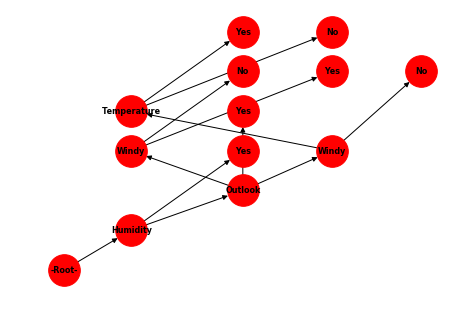

In [16]:
def ContainsPosition(positions, position):
    for pos in positions:
        if positions[pos] == position:
            return True
    return False

def CalculateNodePositions(root, positions, level=0, siblings=0):
    if len(root.children) == 0:
        tentative_pos = (5 + 3, level + 8)
        while ContainsPosition(positions, tentative_pos):
            tentative_pos = (tentative_pos[0] + 3 + 1, level + 8)
                               
        positions[root] = tentative_pos
        #print("Node at " + str(tentative_pos))
        return
    
    for i in range(len(root.children)):
        child = root.children[i]
        tentative_pos = (i * 5 + 3, level + 8)
        while ContainsPosition(positions, tentative_pos):
            tentative_pos = (tentative_pos[0] + 3 + 1, level + 8)
                               
        positions[child] = tentative_pos
        #print("Node at " + str(tentative_pos))
        CalculateNodePositions(child, positions, level + 8, len(root.children))

def ConstructGraph(root, G, labels):
    G.add_node(root)
    if root.parent is not None:
        G.add_edge(root.parent, root)
    if root.is_final_decision:
        labels[root] = "{}".format(root.decision_value)
    else:
        labels[root] = "{}".format(root.attribute_name)
    for child in root.children:
        ConstructGraph(child, G, labels)

positions = {pruned_tree: (0, 0)}
CalculateNodePositions(pruned_tree, positions)

G = nx.DiGraph()
labels = {}
ConstructGraph(pruned_tree, G, labels)
nx.draw(G, pos=positions, 
        labels=labels, 
        with_labels=True,
        font_weight='bold',
        font_size=8, 
        node_size=1000)
plt.savefig("Graph.png", format="PNG")

Usando este conjunto de datos (aunque con una separación diferente en los conjuntos de Prueba/Entrenamiento), la herramienta Weka genera este árbol:

```
Outlook = Sunny
|   Humidity <= 75: Yes (2.0)
|   Humidity > 75: No (3.0)
Outlook = Overcast: Yes (4.0)
Outlook = Rainy
|   Windy = False: Yes (3.0)
|   Windy = True: No (2.0)
```

A simple vista el árbol generado por Weka parece diferente al árbol generado por nuestra implementación, sin embargo se observa que nuestro árbol verifica los valores de frontera de la Humedad y Temperatura en algunos casos (condiciones que nunca se cumplirán), considerando el pequeño tamaño del conjunto de entrenamiento (y la configuración de intervalo de confianza usada) las decisiones tomadas con ambos árboles serán equivalentes.

### Referencias

[1] Ocw.mit.edu. (2019). MIT 15.097 Course Notes. [online] Available at: https://ocw.mit.edu/courses/sloan-school-of-management/15-097-prediction-machine-learning-and-statistics-spring-2012/lecture-notes/MIT15_097S12_lec08.pdf [Accessed 17 Mar. 2019].

[2] Cao, R. and Xu, L. (2009). Improved C4.5 Algorithm for the Analysis of Sales. 2009 Sixth Web Information Systems and Applications Conference.

[3] Quinlan, J. (1996). Improved Use of Continuous Attributes in C4.5. Journal of Artificial Intelligence Research, 4, pp.77-90.

[4] Ruggieri, S. (2002). Efficient C4.5 [classification algorithm]. IEEE Transactions on Knowledge and Data Engineering, 14(2), pp.438-444.
